<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/health_dental_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3조. 건강검진 데이터를 활용한 치석 발생 예측

## - Version 3. 변수 파생 (Next Step. 추가 외부 변수 결합)'

## 1. 작업 환경 세팅

### 1-1. 구글 드라이브 인증

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
# from google.colab import auth
# auth.authenticate_user()
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 학교 g suite 구글 드라이브에 연결해 놓았으니, 성대 킹고 로그인해서 구글 드라이브 켜놓고 아래 결과창에 나오는 url 클릭해서 성대 gmail로 로그인하면 됨

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls /gdrive/My\ Drive/sds/data

 NHIS_OPEN_GJ_2012.csv
 NHIS_OPEN_GJ_2013.csv
 NHIS_OPEN_GJ_2014.csv
 NHIS_OPEN_GJ_2015.csv
 NHIS_OPEN_GJ_2016.csv
 NHIS_OPEN_GJ_2017.csv
'NHIS_OPEN_GJ 건강검진 데이터 연도별 데이터 레이아웃.xlsx'
 NHIS_OPEN_T20_2012.csv
 NHIS_OPEN_T20_2013.csv
 NHIS_OPEN_T20_2014.csv
 NHIS_OPEN_T20_2015.csv
 NHIS_OPEN_T20_2016.csv
 NHIS_OPEN_T20_2017.csv
'NHIS_OPEN_T20 진료내역정보_활용방안.txt'


### 1-2. 라이브러리 로딩

In [3]:
# 기본 라이브러리 로드
import pandas as pd

# pd.set_option('display.float_format', '{:.6f}'.format) # 항상 float 형식으로
# pd.set_option('display.float_format', '{:.2e}'.format) # 항상 사이언티픽
# pd.set_option('display.float_format', '{:.2g}'.format)  # 적당히 알아서
# pd.set_option('display.float_format', None) # option 삭제

import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier


# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn import model_selection

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [4]:
# 한글 글꼴 최초 설치 Version
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!cp /usr/share/fonts/truetype/nanum/NanumGothicEco.ttf /gdrive/My\ Drive/CustomClasses/NanumGothicEco.ttf
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자

# 한글 글꼴 Load
# path = '/gdrive/My Drive/CustomClasses/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 우선 fm._rebuild() 를 해주고 
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
cp: cannot create regular file '/gdrive/My Drive/CustomClasses

## 2. 파일 Read 및 기초 탐색

In [5]:
# DataFrame Load
df_raw_2014 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2014.csv', encoding = 'euc-kr')
df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2014.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 데이터 구조 확인
display(df_raw_2014.head(2))
display(df_raw_2015.head(2))

,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석유무,데이터기준일자
0,2014,1,1,6,42,180,75,79,1.5,1.2,1.0,1.0,110,70,84,203,315,44,96.0,15.9,1.0,1.2,31,18,23,3.0,0.0,1,0.0,0.0,20161220
1,2014,2,2,18,41,150,65,79,0.1,0.1,1.0,1.0,135,80,165,168,60,50,106.0,10.6,1.0,0.8,11,4,15,1.0,1.0,0,NaN,NaN,20161220


,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석유무,데이터기준일자
0,2015,1,2,15,45,155,60,88,0.6,0.7,1.0,2.0,112,74,180,169,175,43,91.0,9.8,1.0,1.1,17,28,23,1.0,1.0,0,NaN,NaN,20161220
1,2015,2,2,15,11,155,65,98,1.2,0.6,1.0,1.0,130,80,179,162,150,53,79.0,13.5,1.0,1.0,25,30,41,1.0,1.0,1,NaN,0.0,20161220


### 2-1. 컬럼명 정제 및 기초 탐색

In [0]:
# 데이터 결합 및 구강검진검수여부 기준 데이터 생성
df_raw = pd.concat([df_raw_2014, df_raw_2015])
df_raw = df_raw[df_raw['구강검진수검여부']==1]

del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '데이터기준일자', '구강검진수검여부']
df_raw.drop(columns=del_cols, axis=1, inplace=True)
df_raw.rename(columns={'치석유무': '치석'}, inplace=True)

df_data = df_raw[~(df_raw['치석'].isnull()) & (df_raw['치석'] != 2)]

## 3. Simple EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

#### 3-2-1. 데이터 NULL 값의 비중이 크지 않으므로 일단 null 값을 모두 삭졔
 . 가장 많은 Null값을 갖고 있는 요단백의 경우 추후 분석 시, 모델에 끼치는 영향이 크다고 할 시, Imputation 고려

In [0]:
# (일단 임시로) null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)

df_data = df_data.sample(n=100000, random_state=42, replace = False ).copy()

# 범주형, 연속형 변수 type 지정
# 명목형 변수는 obj로 연속형 변수는 int 또는 float로 변경
category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백']

for col in df_data.columns:
  if col in category_features:
    df_data[col] = df_data[col].astype(object)

In [0]:
# 단변수 탐색

category_features = [col for col in df_data.columns if df_data[col].dtypes == "object"]
cat_cols = list(set(category_features) - set(['치석']))

numeric_features = [col for col in df_data.columns if df_data[col].dtypes != "object"]
numeric_features = np.sort(numeric_features)

num_cols = list(set(numeric_features) - set(['치석']))

In [0]:
# 수치형 변수들에 log를 취한 값 산출

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: str(x)+"_LN", num_cols))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_data[num_cols])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

In [0]:
df_data.drop_duplicates()
df_data.reset_index(inplace=True, drop=True)

df_fe = pd.concat([df_data, piped_df], axis=1)

## 4. Feature Engineering

### 4-1. Feature Engineering 변수 추가

#### 4-1-1. 데이터셋 내 내부 변수의 범주화를 통한 신규 변수 추출

In [0]:
# 기존 수치형 변수들을 LN 변수들로 치환
# df_fe.drop(columns=numeric_feature, axis=1, inplace=True)

# BMI 변수 추가
df_fe["A_BMI"] = (df_fe["체중5Kg단위"]/(df_fe["신장5Cm단위"]*df_fe["신장5Cm단위"])).astype(float)

# 공복 혈당 
# 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# 당뇨병의 중간인 100~125 mg/dL가 나오거나 

df_fe["A_diabetes"] = np.where(df_fe['식전혈당공복혈당'].between(0, 100, inclusive=True), '정상', 
                               np.where(df_fe['식전혈당공복혈당'].between(100, 124.9, inclusive=True), '당뇨전단계', 
                                        '당뇨')
                              )

# HDL 콜레스테롤
# HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
df_fe["A_HDL"] = np.where(
                    (df_fe['성별코드'].astype('int') == 2) & (df_fe['HDL콜레스테롤']<= 50), '고위험', 
                       np.where(
                         (df_fe['성별코드'].astype('int') == 2) & (df_fe['HDL콜레스테롤'].between(50, 59.9, inclusive=True)), '위험', 
                           np.where(
                               (df_fe['성별코드'].astype('int') == 1) & (df_fe['HDL콜레스테롤']<= 40), '고위험', 
                                      np.where(
                                          (df_fe['성별코드'].astype('int') == 1) & (df_fe['HDL콜레스테롤'].between(40, 49.9, inclusive=True)), '위험', '정상')
                          )))
# LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# 100 mg/dL (2.59mmol/L) 미만 – 최적
# 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# 190 mg/dL (4.90 mmol) 이상 – 매우 높음
df_fe["A_LDL"] = np.where(df_fe['LDL콜레스테롤']<100, '최적', 
                    np.where(df_fe['LDL콜레스테롤'].between(100, 122.9, inclusive=True), '최적인접', 
                             np.where(df_fe['LDL콜레스테롤'].between(130, 159.9, inclusive=True), '상한경계', 
                                      np.where(df_fe['LDL콜레스테롤'].between(160, 189.9, inclusive=True), '높음', '매우높음')
                              )))

# 트리글리세라이드
# 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# 150 mg/dL (1.7 mmol/L) 미만: 바람직
# 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
df_fe["A_TRI"] = np.where(df_fe['트리글리세라이드']<150, '바람직', 
                    np.where(df_fe['트리글리세라이드'].between(150, 199.9, inclusive=True), '경계성증가', 
                             np.where(df_fe['트리글리세라이드'].between(200, 499.9, inclusive=True), '증가', '매우증가')
                              ))

# 혈색소
# 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# 18그램 이상: 폐질환 등 기타 이상
# 12그램 미만: 빈혈
df_fe["A_HEMO"] = np.where(df_fe['혈색소'].between(12, 17.9, inclusive=True), '정상', 
                    np.where(df_fe['혈색소']>=18, '이상', '빈혈'))

# 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# 요단백은 보통 소변에서 검출 되지 않음- 검출 되면 
df_fe["A_PIU"] = np.where(df_fe['요단백']==1, '정상', '이상')

# 혈중 크레아티닌 농도의 
# 정상범위는 0.50~1.4 mg/dL 입니다
# 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
df_fe["A_CRE"] = np.where(df_fe['혈청크레아티닌'].between(0.5, 1.4, inclusive=True), '정상', '이상')

# 혈청지오티AST:
#  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# 혈청지오티ALT:
# 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# 증가: 간질환, 심근경색, 지방간, 비만


# 감마지티피
# 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# 남자는 50IU 이하, 여자는 32IU이하가 정상
# 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# 500 이상이면 황달
df_fe["A_GTP"] = np.where((df_fe['감마지티피'] >= 500), '황달', 
                       np.where(df_fe['감마지티피']>=200, '담도이상', 
                           np.where(df_fe['감마지티피']>= 100, '이상가능', 
                             np.where((df_fe['성별코드'].astype('int') == 1) & (df_fe['감마지티피']<=50), '정상',
                              np.where((df_fe['성별코드'].astype('int') == 2) & (df_fe['감마지티피']<=32), '정상', '체크')
                          ))))

In [12]:
# Feature Engineering 이후 불필요컬럼 Dropt
df_final = df_fe[['시도코드','흡연상태','연령대코드5세단위','혈청크레아티닌','혈색소','감마지티피','체중5Kg단위','성별코드','신장5Cm단위','시력우','시력좌','허리둘레','트리글리세라이드','혈청지오티ALT','음주여부','A_GTP','A_BMI','A_TRI','이완기혈압','HDL콜레스테롤','수축기혈압','치석']].copy()
df_final.columns

Index(['시도코드', '흡연상태', '연령대코드5세단위', '혈청크레아티닌', '혈색소', '감마지티피', '체중5Kg단위',
       '성별코드', '신장5Cm단위', '시력우', '시력좌', '허리둘레', '트리글리세라이드', '혈청지오티ALT', '음주여부',
       'A_GTP', 'A_BMI', 'A_TRI', '이완기혈압', 'HDL콜레스테롤', '수축기혈압', '치석'],
      dtype='object')

In [0]:
# 상관계수 검증을 위한 연속형 변수 탐색
num_features_after_fe = [col for col in df_final.columns if df_final[col].dtypes != "object"]
num_features_after_fe = np.sort(num_features_after_fe)

num_input = list(set(num_features_after_fe) - set(['치석']))

### 모델 입력 전 최종 모델 입력에 맞게 입력 데이터 변형

In [0]:
data_x = df_final[df_final.columns.difference(['치석'])]
data_y = df_final['치석'].astype('float64')

In [15]:
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set(['치석']))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['이완기혈압', '시력우', '혈색소', 'A_BMI', '트리글리세라이드', '감마지티피', '허리둘레', '혈청지오티ALT', '시력좌', '혈청크레아티닌', 'HDL콜레스테롤', '수축기혈압']
cat_attribs:  ['A_GTP', 'A_TRI', '성별코드', '시도코드', '신장5Cm단위', '연령대코드5세단위', '음주여부', '체중5Kg단위', '흡연상태']


In [0]:
# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.3, random_state = 0)

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.GradientBoostingClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
     
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

In [19]:
# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(70000, 1)


In [20]:
# MLA_predict
['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']

['LogisticRegressionCV',
 'RidgeClassifierCV',
 'AdaBoostClassifier',
 'GradientBoostingClassifier',
 'LinearDiscriminantAnalysis',
 'XGBClassifier']

In [0]:
from sklearn import tree, linear_model, naive_bayes, ensemble

# evaluation package
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

In [0]:
cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size =.6, random_state=42) # run model 10x with 60/30 split intentionally leaving out 10%
verboseNo = 1

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [24]:
# LogisticRegressionCV
model_lr = linear_model.LogisticRegression()

param_grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}

grid_lr = GridSearchCV(model_lr,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_lr.fit(train_x, train_y)
grid_lr_best = grid_lr.best_estimator_
print(grid_lr_best)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 12.7min finished


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Accuracy: 0.57407
Confusion Matrix: 
 [[ 5634  8351]
 [ 4427 11588]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.40      0.47     13985
         1.0       0.58      0.72      0.64     16015

    accuracy                           0.57     30000
   macro avg       0.57      0.56      0.56     30000
weighted avg       0.57      0.57      0.56     30000

0.5632159294708404


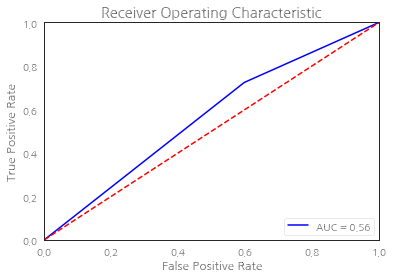

In [25]:
pred_y_lr = grid_lr_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_lr)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_lr))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_lr))

roc_auc_lr = roc_auc_score(test_y, pred_y_lr)
print(roc_auc_lr)

fpr, tpr, threshold = roc_curve(test_y, pred_y_lr)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [26]:
# RidgeClassifierCV
model_rc = linear_model.RidgeClassifier()

param_grid = {'alpha':[1e-3, 1e-2, 1e-1, 1]}

grid_rc = GridSearchCV(model_rc,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_rc.fit(train_x, train_y)
grid_rc_best = grid_rc.best_estimator_
print(grid_rc_best)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.4s finished


Accuracy: 0.57927
Confusion Matrix: 
 [[ 5983  8002]
 [ 4620 11395]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.43      0.49     13985
         1.0       0.59      0.71      0.64     16015

    accuracy                           0.58     30000
   macro avg       0.58      0.57      0.57     30000
weighted avg       0.58      0.58      0.57     30000

0.5696679831017377


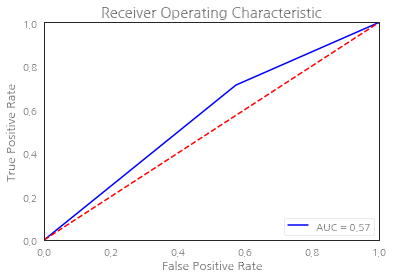

In [27]:
pred_y_rc = grid_rc_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_rc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_rc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_rc))

roc_auc_rc = roc_auc_score(test_y, pred_y_rc)
print(roc_auc_rc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_rc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [28]:
# AdaBoostClassifier
model_ab = ensemble.AdaBoostClassifier()

param_grid = {'n_estimators': [16, 32]}

grid_ab = GridSearchCV(model_ab,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ab.fit(train_x, train_y)
grid_ab_best = grid_ab.best_estimator_
print(grid_ab_best)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   33.1s finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=32, random_state=None)


Accuracy: 0.57817
Confusion Matrix: 
 [[ 5957  8028]
 [ 4627 11388]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.43      0.48     13985
         1.0       0.59      0.71      0.64     16015

    accuracy                           0.58     30000
   macro avg       0.57      0.57      0.56     30000
weighted avg       0.58      0.58      0.57     30000

0.5685198705941461


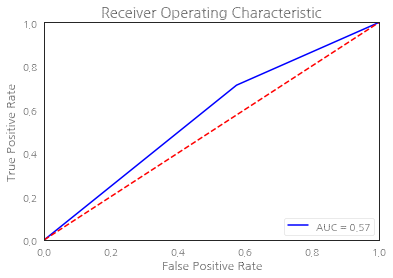

In [29]:
pred_y_ab = grid_ab_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ab)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ab))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ab))

roc_auc_ab = roc_auc_score(test_y, pred_y_ab)
print(roc_auc_ab)

fpr, tpr, threshold = roc_curve(test_y, pred_y_ab)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [30]:
# GradientBoostingClassifier
model_gb = ensemble.GradientBoostingClassifier()

param_grid = {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}

grid_gb = GridSearchCV(model_gb,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_gb.fit(train_x, train_y)
grid_gb_best = grid_gb.best_estimator_
print(grid_gb_best)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=16,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Accuracy: 0.57597
Confusion Matrix: 
 [[ 5855  8130]
 [ 4591 11424]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.42      0.48     13985
         1.0       0.58      0.71      0.64     16015

    accuracy                           0.58     30000
   macro avg       0.57      0.57      0.56     30000
weighted avg       0.57      0.58      0.57     30000

0.5659970525040711


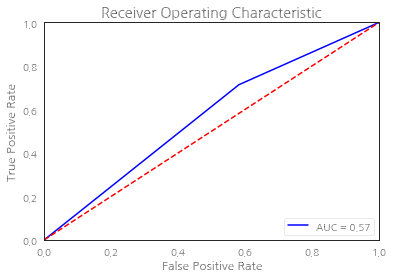

In [31]:
pred_y_gb = grid_gb_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_gb)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_gb))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_gb))

roc_auc_gb = roc_auc_score(test_y, pred_y_gb)
print(roc_auc_gb)

fpr, tpr, threshold = roc_curve(test_y, pred_y_gb)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [32]:
# LinearDiscriminantAnalysis
## LDA(선형판별분석(Linear Discriminant Analysis):데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표
model_ld = discriminant_analysis.LinearDiscriminantAnalysis()

param_grid = {'solver': ['svd', 'lsqr']}

grid_ld = GridSearchCV(model_ld,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_ld.fit(train_x, train_y)
grid_ld_best = grid_ld.best_estimator_
print(grid_ld_best)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.4s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='lsqr', store_covariance=False, tol=0.0001)


Accuracy: 0.57923
Confusion Matrix: 
 [[ 5987  7998]
 [ 4625 11390]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.43      0.49     13985
         1.0       0.59      0.71      0.64     16015

    accuracy                           0.58     30000
   macro avg       0.58      0.57      0.57     30000
weighted avg       0.58      0.58      0.57     30000

0.569654889817164


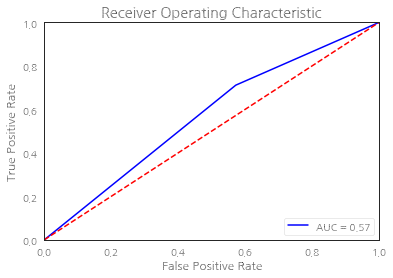

In [33]:
pred_y_ld = grid_ld_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_ld)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_ld))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_ld))

roc_auc_ld = roc_auc_score(test_y, pred_y_ld)
print(roc_auc_ld)

fpr, tpr, threshold = roc_curve(test_y, pred_y_ld)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [34]:
# XGBClassifier
model_xg = XGBClassifier()

param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

grid_xg = GridSearchCV(model_xg,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = verboseNo)
grid_xg.fit(train_x, train_y)
grid_xg_best = grid_xg.best_estimator_
print(grid_xg_best)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.9s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=-999, n_estimators=5, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
              silent=1, subsample=0.8, verbosity=1)


Accuracy: 0.56727
Confusion Matrix: 
 [[ 4711  9274]
 [ 3708 12307]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.56      0.34      0.42     13985
         1.0       0.57      0.77      0.65     16015

    accuracy                           0.57     30000
   macro avg       0.56      0.55      0.54     30000
weighted avg       0.57      0.57      0.55     30000

0.5526639922730645


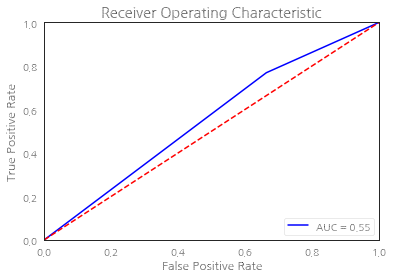

In [35]:
pred_y_xg = grid_xg_best.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_xg)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_xg))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_xg))

roc_auc_xg = roc_auc_score(test_y, pred_y_xg)
print(roc_auc_xg)

fpr, tpr, threshold = roc_curve(test_y, pred_y_xg)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
# # XGBoost Test
# xgb_clf = XGBClassifier(nthreads=-1)

# one_to_left = st.beta(100, 1)  
# from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 100),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.9),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

# rand_search = RandomizedSearchCV(xgb_clf, params, n_jobs=1, cv=100)  
# rand_search.fit(x_train, y_train) 
# xgb_best = rand_search.best_estimator_
# print(rand_search.best_estimator_)

## 결과 앙상블로 모델 결과 최적화

In [0]:
votingC = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),
                                       ('model_gb', grid_gb_best),('model_ld', grid_ld_best), ('model_xg',grid_xg_best)], 
                           voting='soft', n_jobs=-1)

votingC = votingC.fit(train_x, train_y)

Accuracy: 0.57963
Confusion Matrix: 
 [[ 5823  8162]
 [ 4449 11566]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0       0.57      0.42      0.48     13985
         1.0       0.59      0.72      0.65     16015

    accuracy                           0.58     30000
   macro avg       0.58      0.57      0.56     30000
weighted avg       0.58      0.58      0.57     30000

0.569286313298301


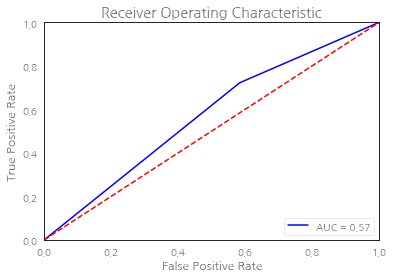

In [38]:
# soft voting을 통한 성능 향상
pred_y_vc = votingC.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc))

roc_auc_vc = roc_auc_score(test_y, pred_y_vc)
print(roc_auc_vc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

In [0]:
import keras
# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:

def mlp_model():
#   input_dim = train_x.shape[1]
#   batch_size = 64
#   epochs = 50

  model = Sequential()

  # 첫 번째 Layer (Input layer)
  model.add(Dense(input_dim=input_dim, init='glorot_uniform', activation=activation, output_dim=128))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 두 번째 Layer (Hidden layer 1)
  model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 세 번째 Layer (Hidden layer 2)
  model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 네 번째 Layer (Hidden layer 3)
  model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 다섯 번째 Layer (Hidden layer 4)
  model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
  model.add(Dropout(0.3)) # 30% 정도를 Drop 

  # 여섯 번째 Layer (Output layer)
  model.add(Dense(output_dim=1))
  model.add(Activation("sigmoid"))

  # Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
  # ffn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1score])
  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', precision, recall, f1score])
  
  return model

# model training
# hist = ffn_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
activation = lrelu

model_dl = KerasClassifier(build_fn = mlp_model, epochs = 50, input_dim = train_x.shape[1], verbose = 1)

In [0]:
model_dl_run = model_dl.fit(train_x, train_y)
pred_y_dl = model_dl_run.predict(test_x)
pred_y_dl = (pred_y_dl>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dl)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dl))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dl))

roc_auc_dl = roc_auc_score(test_y, pred_y_dl)
print(roc_auc_dl)

fpr, tpr, threshold = roc_curve(test_y, pred_y_dl)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)

Epoch 1/50
70000/70000 [==============================] - 15s 211us/step - loss: 0.6838 - acc: 0.5560 - precision: 0.5653 - recall: 0.7276 - f1score: 0.6251
Epoch 2/50
70000/70000 [==============================] - 14s 202us/step - loss: 0.6804 - acc: 0.5679 - precision: 0.5716 - recall: 0.7613 - f1score: 0.6448
Epoch 3/50
60896/70000 [=========================>....] - ETA: 1s - loss: 0.6794 - acc: 0.5699 - precision: 0.5754 - recall: 0.7413 - f1score: 0.6396

In [0]:
votingC = VotingClassifier(estimators=[('model_lr',grid_lr_best),('model_ab', grid_ab_best),('model_gb', grid_gb_best)
                                       ,('model_ld', grid_ld_best), ('model_xg',grid_xg_best), ('model_dl',model_dl)], 
                           voting='soft', n_jobs=-1)

votingC = votingC.fit(train_x, train_y)

In [0]:
# soft voting을 통한 성능 향상
pred_y_vc = votingC.predict(test_x)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_vc)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_vc))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_vc))

roc_auc_vc = roc_auc_score(test_y, pred_y_vc)
print(roc_auc_vc)

fpr, tpr, threshold = roc_curve(test_y, pred_y_vc)
roc_auc = auc(fpr, tpr)

auc_graph(roc_auc, fpr, tpr)